In [1]:
%%javascript
Jupyter.utils.load_extensions('vim_binding/vim_binding');

<IPython.core.display.Javascript object>

In [2]:
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
np.random.seed(3)

In [3]:
# Load environment
data_folder = Path("data/")
building_attributes = data_folder / 'building_attributes.json'
solar_profile = data_folder / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
# building_ids = ["Building_9"] #,"Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
building_ids = ["Building_1","Building_2", "Building_5", "Building_6", "Building_7", "Building_8"] #,"Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
env = CityLearn(building_attributes, solar_profile, building_ids, buildings_states_actions = building_state_actions, cost_function = ['ramping','1-load_factor','peak_to_valley_ratio','peak_demand','net_electricity_consumption'])
observations_spaces,actions_spaces = env.get_state_action_spaces()

In [4]:
#NO STORAGE
env.reset()
done = False
while not done:
    _, rewards, done, _ = env.step([[0 for _ in range(len(actions_spaces[i].sample()))] for i in range(len(building_ids))])
cost_no_es = env.cost()

In [5]:
cost_no_es # costs from CityLearn with no Energy Storage

{'ramping': 0.844342543140669,
 '1-load_factor': 1.0898232067144384,
 'peak_to_valley_ratio': 0.9720856101619892,
 'peak_demand': 1.129586164176868,
 'net_electricity_consumption': 1.0060199255543638,
 'total': 1.0083714899496656}

In [6]:
len(env.net_electric_consumption)

1007

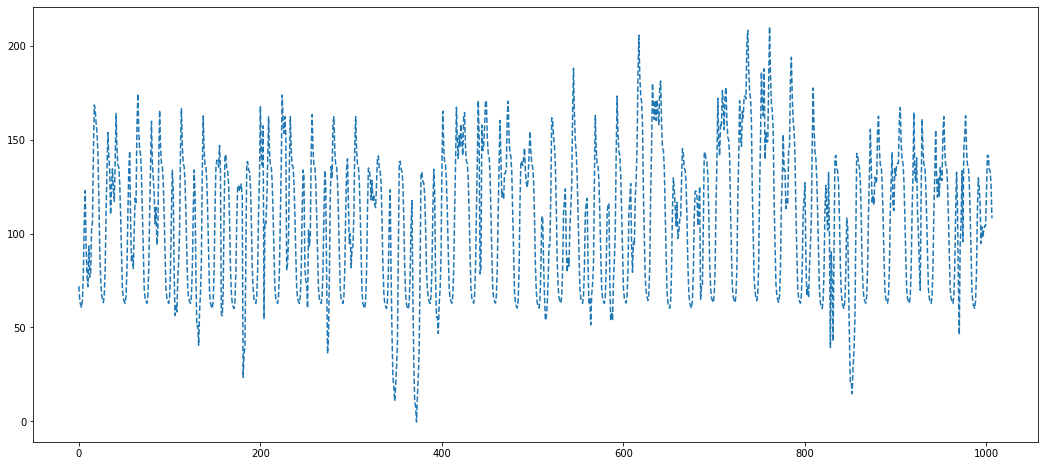

In [7]:
interval = range(0,1008)
plt.figure(figsize=(18,8))
# plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
# plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption, '--')
# plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand(kW)'])
from copy import deepcopy
donothing = deepcopy(env.net_electric_consumption)

In [8]:
print(np.mean(env.net_electric_consumption), np.var(env.net_electric_consumption))

107.28336122707665 1413.3619548396978


In [9]:
#RULE-BASED CONTROLLER (Stores energy at night and releases it during the day)
from citylearn import RBC_Agent

#Instantiatiing the control agent(s)
agents = RBC_Agent(actions_spaces)

state = env.reset()
done = False
while not done:
    action = agents.select_action(state)
    next_state, rewards, done, _ = env.step(action)
    state = next_state
cost_rbc = env.cost()

In [10]:
cost_rbc #cost from CityLearn with Energy Storage and using a Rule-based controller (can be compared with the RL controller for benchmarking) 15918.64

{'ramping': 1.0,
 '1-load_factor': 1.0,
 'peak_to_valley_ratio': 1.0,
 'peak_demand': 1.0,
 'net_electricity_consumption': 1.0,
 'total': 1.0}

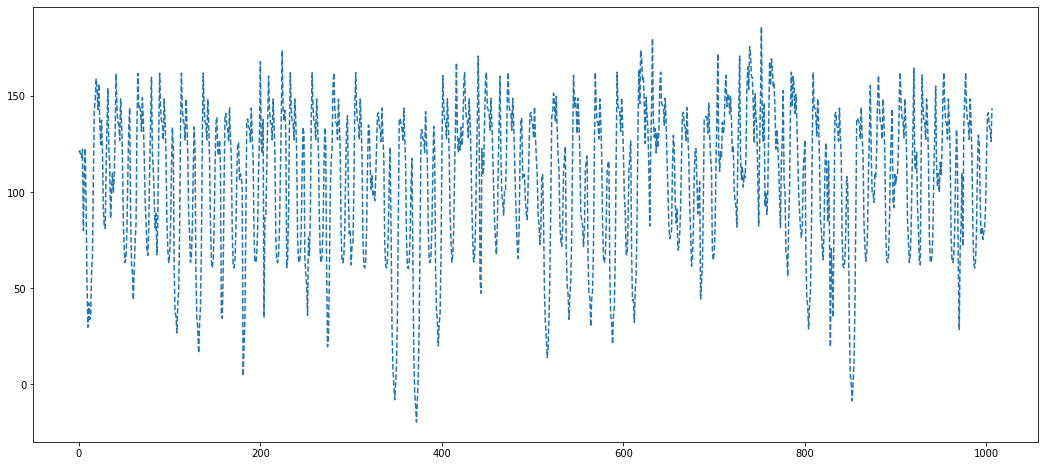

In [11]:
# interval = range(0,8759)
interval = range(0,1008)
plt.figure(figsize=(18,8))
# plt.plot(env.net_electric_consumption[interval]+env.electric_generation[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
# plt.plot(env.net_electric_consumption[interval]-env.electric_consumption_cooling_storage[interval]-env.electric_consumption_dhw_storage[interval])
plt.plot(env.net_electric_consumption, '--')
# plt.legend(['Electricity demand without storage or generation (kW)', 'Electricity demand with PV generation and without storage(kW)', 'Electricity demand using RBC for storage(kW)'])

In [12]:
import numpy as np

In [13]:
rl = np.loadtxt('rl.csv', delimiter=',', skiprows=1)

print(rl.shape)

(1000, 3)


In [14]:
from collections import defaultdict, Counter
a = defaultdict(list)
b = Counter()
for i in range(len(rl)):
    a[int(rl[i, 1]) % 1008].append(rl[i, 2])
for i in range(1008):
    if len(a[i]):
        b[i] = np.mean(a[i])
rlx, rly = [], []
for k in b.keys():
    rlx.append(k)
    rly.append(b[k])


Text(0, 0.5, 'Electricity Consumption')

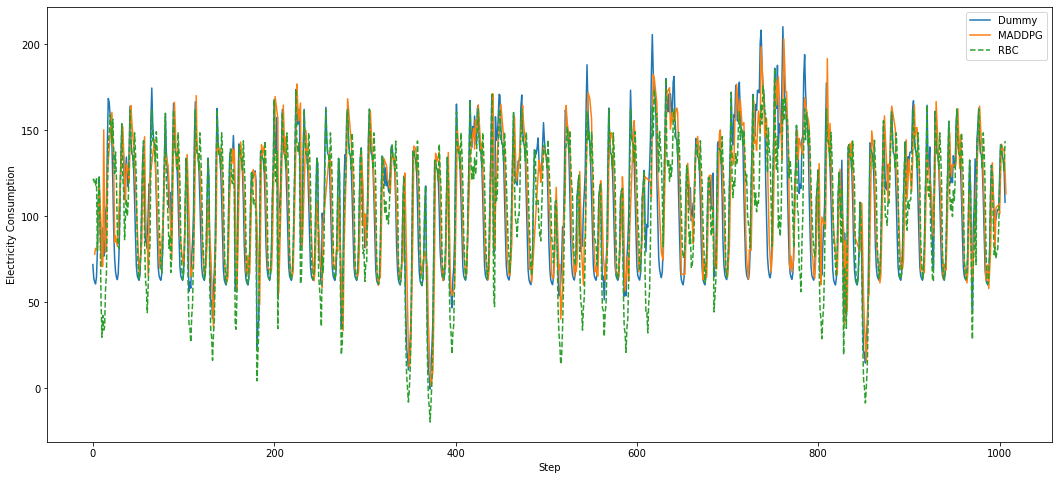

In [21]:
interval = range(0,1008)
plt.figure(figsize=(18,8))
plt.plot(donothing)
plt.plot(rlx, rly)
plt.plot(env.net_electric_consumption, '--')
plt.legend(['Dummy', 'MADDPG', 'RBC'])
plt.xlabel('Step')
plt.ylabel('Electricity Consumption')

In [16]:
print('mean of maddpg %f, rbc %f' % (np.mean(rly), np.mean(env.net_electric_consumption)))
print('var of maddpg %f, rbc %f' % (np.var(rly), np.var(env.net_electric_consumption)))

mean of maddpg 108.746488, rbc 106.583226
var of maddpg 1356.698914, rbc 1439.924498
